# Problem



```
* Przewidzieć czy Movie czy TV Show na podstawie danych dostępnych na Kaggle.
* Analiza różnych wariantów klasyfikatorów
* Analiza ważności cech
```



# Dane



```
Dane pochodzą z serwisu Kaggle, zawierają informacje o filmach i serialach serwisu Netflix:
https://www.kaggle.com/datasets/shivamb/netflix-shows/data
```



# Opis danych



```
Dane rzeczywiste dotyczące filmów i seriali na Netflixie.
Dane opisane są 12 atrybutami, w tym atrybut decyzyjny "type".

Input(X) = wszystkie atrybuty poza atrybutem "type"
Output(y) = atrybut "type"
```





```
# TV-Y      – dla najmłodszych dzieci (All Children)
# TV-Y7     – dla dzieci powyżej 7 lat (Directed to Older Children)
# TV-Y7-FV  – dla dzieci powyżej 7 lat z elementami fantastycznej przemocy (Fantasy Violence)
# TV-G      – dla wszystkich widzów (General Audience)
# TV-PG     – pod opieką rodziców (Parental Guidance Suggested)
# TV-14     – dla widzów powyżej 14 roku życia (Parents Strongly Cautioned)
# TV-MA     – tylko dla dorosłych (Mature Audience Only)
# G         – dla wszystkich widzów (General Audiences)
# PG        – dla dzieci pod opieką dorosłych (Parental Guidance Suggested)
# PG-13     – dla widzów powyżej 13 roku życia (Parents Strongly Cautioned)
# R         – dla dorosłych, osoby poniżej 17 lat tylko z opiekunem (Restricted)
# NC-17     – wyłącznie dla dorosłych (Adults Only)
# NR        – brak klasyfikacji (Not Rated)
# UR        – nieoceniony film (Unrated)
# min       – błąd w danych (np. 84 min zamiast ratingu)
```



# Importowanie bibliotek

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict

# Wczytanie danych

In [4]:
path = "netflix_titles.csv"
data = pd.read_csv(path)

# Eksploracja danych

In [5]:
data.head(3)
# zauważamy, że dane posiadają wartości NaN, różne formaty dla "duration", "type" danych to Movie/TV Show

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


In [6]:
data.shape # liczba wierszy, kolumn

(8807, 12)

In [7]:
typ_danych = data.dtypes
print(f"Typ danych:\n{typ_danych}")
# większość danych to dane dyskretne, oprócz kolumny numerycznej "release_year"
data.select_dtypes(include = "int64")

Typ danych:
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


,release_year
0,2020
1,2021
2,2021
3,2021
4,2021
...,...
8802,2007
8803,2018
8804,2009
8805,2006


In [8]:
# info. o danych: ilość rekordów niepustych, typy zmiennych
data.info()

puste = data.isnull().sum()
print(f"\nKolumny z NaN:\n{puste}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

Kolumny z NaN:
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
descr

In [9]:
# rozkład targetu (atrybut decyzyjny y)
type_counts = data["type"].value_counts()
print(type_counts)

type
Movie      6131
TV Show    2676
Name: count, dtype: int64


In [10]:
# Podział zbioru na atrybut decyzyjny i reszte atrybutów
X = data.drop(columns = "type")
y = data["type"]

In [11]:
# transformacja danych - LabelEncoder

le_list = []

for col in X.columns:
    if X[col].dtype == "object":
        le = LabelEncoder()
        X[col] = X[col].astype(str).fillna("missing")
        X[col]= le.fit_transform(X[col])
        le_list.append(le)
    else:
        le_list.append(None)


# Uczenie

In [12]:
# Podział zbioru na treningowy i testowy
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size = 0.3, random_state = 42)

Klasyfikator DT 4
Confusion matrix:
[[1792   44]
 [  18  789]]


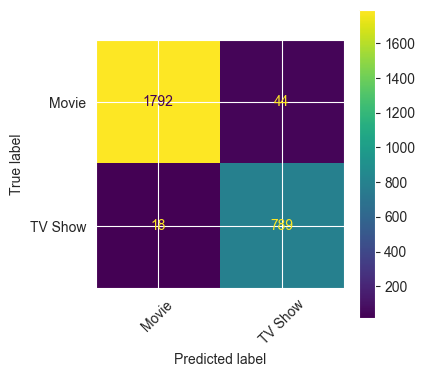

Report:
              precision    recall  f1-score   support

       Movie       0.99      0.98      0.98      1836
     TV Show       0.95      0.98      0.96       807

    accuracy                           0.98      2643
   macro avg       0.97      0.98      0.97      2643
weighted avg       0.98      0.98      0.98      2643

Precision: 0.9769635965962257 
--------------------------------------------------
Klasyfikator DT 6
Confusion matrix:
[[1810   26]
 [  20  787]]


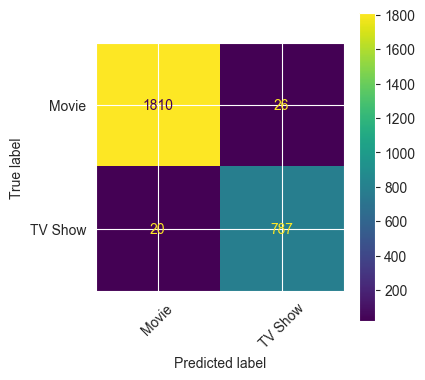

Report:
              precision    recall  f1-score   support

       Movie       0.99      0.99      0.99      1836
     TV Show       0.97      0.98      0.97       807

    accuracy                           0.98      2643
   macro avg       0.98      0.98      0.98      2643
weighted avg       0.98      0.98      0.98      2643

Precision: 0.9826433250655797 
--------------------------------------------------
Klasyfikator DT 8
Confusion matrix:
[[1815   21]
 [  18  789]]


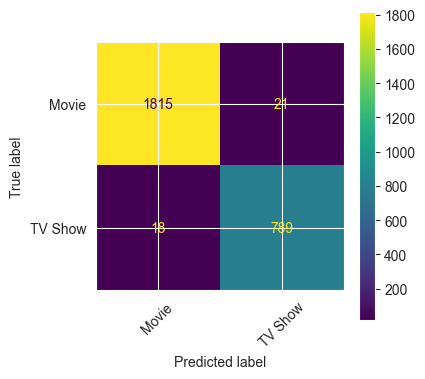

Report:
              precision    recall  f1-score   support

       Movie       0.99      0.99      0.99      1836
     TV Show       0.97      0.98      0.98       807

    accuracy                           0.99      2643
   macro avg       0.98      0.98      0.98      2643
weighted avg       0.99      0.99      0.99      2643

Precision: 0.9852623223140285 
--------------------------------------------------
Klasyfikator RF 200
Confusion matrix:
[[1826   10]
 [  17  790]]


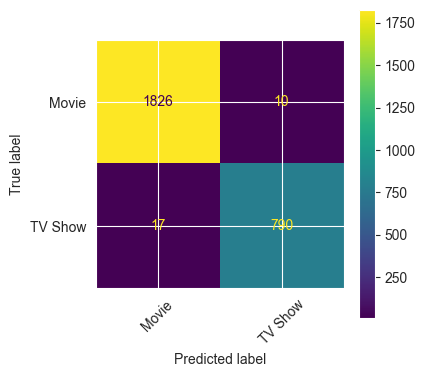

Report:
              precision    recall  f1-score   support

       Movie       0.99      0.99      0.99      1836
     TV Show       0.99      0.98      0.98       807

    accuracy                           0.99      2643
   macro avg       0.99      0.99      0.99      2643
weighted avg       0.99      0.99      0.99      2643

Precision: 0.9897756597192926 
--------------------------------------------------
Klasyfikator RF 100
Confusion matrix:
[[1825   11]
 [  17  790]]


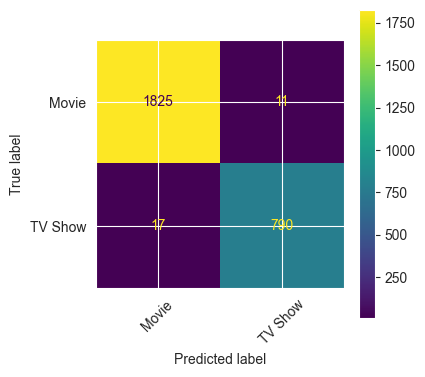

Report:
              precision    recall  f1-score   support

       Movie       0.99      0.99      0.99      1836
     TV Show       0.99      0.98      0.98       807

    accuracy                           0.99      2643
   macro avg       0.99      0.99      0.99      2643
weighted avg       0.99      0.99      0.99      2643

Precision: 0.9893957539118762 
--------------------------------------------------
Klasyfikator RF
Confusion matrix:
[[1825   11]
 [  17  790]]


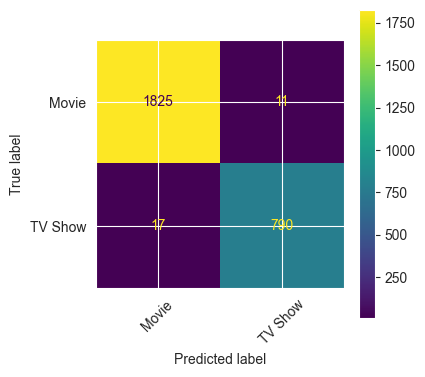

Report:
              precision    recall  f1-score   support

       Movie       0.99      0.99      0.99      1836
     TV Show       0.99      0.98      0.98       807

    accuracy                           0.99      2643
   macro avg       0.99      0.99      0.99      2643
weighted avg       0.99      0.99      0.99      2643

Precision: 0.9893957539118762 
--------------------------------------------------
Klasyfikator AdaBoost 200
Confusion matrix:
[[1833    3]
 [   7  800]]


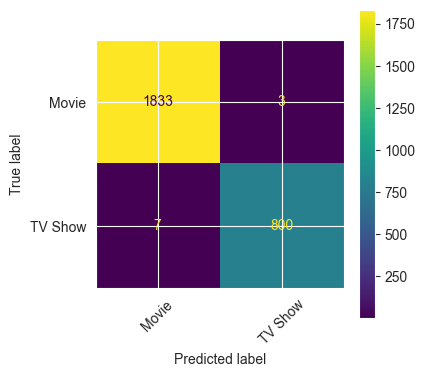

Report:
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1836
     TV Show       1.00      0.99      0.99       807

    accuracy                           1.00      2643
   macro avg       1.00      0.99      1.00      2643
weighted avg       1.00      1.00      1.00      2643

Precision: 0.9962165241888591 
--------------------------------------------------
Klasyfikator AdaBoost
Confusion matrix:
[[1810   26]
 [  20  787]]


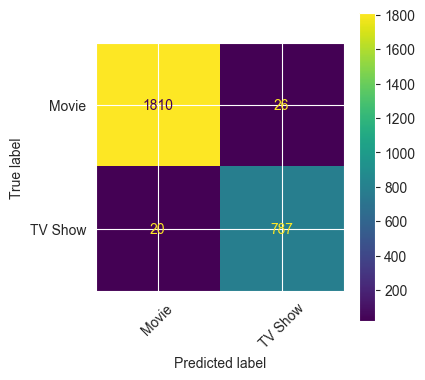

Report:
              precision    recall  f1-score   support

       Movie       0.99      0.99      0.99      1836
     TV Show       0.97      0.98      0.97       807

    accuracy                           0.98      2643
   macro avg       0.98      0.98      0.98      2643
weighted avg       0.98      0.98      0.98      2643

Precision: 0.9826433250655797 
--------------------------------------------------
Klasyfikator LR
Confusion matrix:
[[1709  127]
 [ 129  678]]


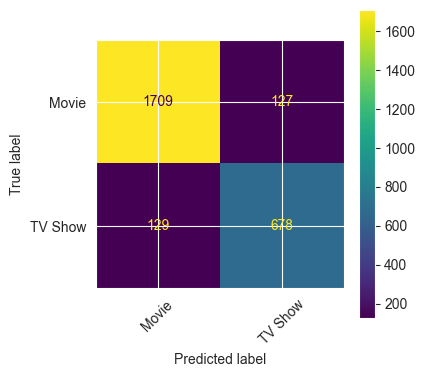

Report:
              precision    recall  f1-score   support

       Movie       0.93      0.93      0.93      1836
     TV Show       0.84      0.84      0.84       807

    accuracy                           0.90      2643
   macro avg       0.89      0.89      0.89      2643
weighted avg       0.90      0.90      0.90      2643

Precision: 0.9030740983795101 
--------------------------------------------------
Najlepszy klasyfikator to AdaBoost 200


In [13]:
clf_dict = {
    "DT 4" : DecisionTreeClassifier(max_depth = 4,random_state = 42,
                                    class_weight = "balanced"),
    "DT 6" : DecisionTreeClassifier(max_depth = 6,random_state = 42,
                                    class_weight = "balanced"),
    "DT 8" : DecisionTreeClassifier(max_depth = 8,random_state = 42,
                                    class_weight = "balanced"),
    "RF 200" : RandomForestClassifier(n_estimators=200, random_state = 42),
    "RF 100" : RandomForestClassifier(n_estimators=100, random_state = 42),
    "RF" : RandomForestClassifier(random_state = 42),
    "AdaBoost 200": AdaBoostClassifier(n_estimators=200, random_state = 42),
    "AdaBoost": AdaBoostClassifier(random_state = 42),
    "LR" : LogisticRegression(random_state = 42, penalty = "l2", solver = "lbfgs", max_iter=1000)
}

best_clf = ("Brak", None, 0.0) # tu będzie zapisywany najlepszy klasyfikator

for name, clf in clf_dict.items():
    print("Klasyfikator", name)
    clf.fit(X_tr,y_tr)
    y_pred = clf.predict(X_te)

    cm = confusion_matrix(y_te,y_pred)
    print(f"Confusion matrix:\n{cm}")

    from sklearn import metrics
    labels = sorted(y.unique())
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    fig, ax = plt.subplots(figsize=(4,4))
    cm_display.plot(ax=ax)
    plt.xticks(rotation = 45)
    plt.show()

    report = classification_report(y_te,y_pred, zero_division=0.0)
    print(f"Report:\n{report}")

    prec = precision_score(y_te, y_pred, average ="weighted")
    if prec>best_clf[2]:
        best_clf = (name,clf,prec)

    print(f"Precision: {prec} ")
    print("-"*50)
print(f"Najlepszy klasyfikator to {best_clf[0]}")

# Budujemy ostateczny model

In [14]:
clf = clf_dict[best_clf[0]]
print(f"Najlepszy klasyfikator, to {best_clf[0]}")
clf.fit(X,y)

# Wytrenowany klasyfikator do użytkowania
new_data = X_te.sample(1,random_state=42)

result = clf.predict(new_data)
print(f"\nPrzewidywany typ: {result[0]}")

Najlepszy klasyfikator, to AdaBoost 200

Przewidywany typ: Movie


#CV

In [15]:
clf_dict = {
    "DT 4" : DecisionTreeClassifier(max_depth = 4,random_state = 42,
                                    class_weight = "balanced"),
    "DT 6" : DecisionTreeClassifier(max_depth = 6,random_state = 42,
                                    class_weight = "balanced"),
    "DT 8" : DecisionTreeClassifier(max_depth = 8,random_state = 42,
                                    class_weight = "balanced"),
    "RF 200" : RandomForestClassifier(n_estimators=200, random_state = 42),
    "RF 100" : RandomForestClassifier(n_estimators=100, random_state = 42),
    "RF" : RandomForestClassifier(random_state = 42),
    "AdaBoost 200": AdaBoostClassifier(n_estimators=200, random_state = 42),
    "AdaBoost": AdaBoostClassifier(random_state = 42),
    "LR" : LogisticRegression(random_state = 42, penalty = "l2", solver = "lbfgs", max_iter=1000)
}

best_clf = ("Brak", 0.0) # tu będzie zapisywany najlepszy klasyfikator

for name, clf in clf_dict.items():
    results = cross_val_score(clf, X, y, scoring = "precision_macro",cv = 10)
    acc = sum(results)/len(results)
    print(name,":",acc)

    if acc>best_clf[1]:
        best_clf = (name, acc)

DT 4 : 0.9665151070247703
DT 6 : 0.9791083019599984
DT 8 : 0.984159814546152
RF 200 : 0.9860584634203693
RF 100 : 0.986727291730441
RF : 0.986727291730441
AdaBoost 200 : 0.9946873013525528
AdaBoost : 0.982747452290468


/Users/nasia/Documents/Git/Portfolio/Netflix_ratings_klasyfikacja/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nasia/Documents/Git/Portfolio/Netflix_ratings_klasyfikacja/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You migh

LR : 0.8793468878861935


In [16]:
clf = clf_dict[best_clf[0]]
print(f"Najlepszy klasyfikator, to {best_clf[0]}")
clf.fit(X,y)

# Wytrenowany klasyfikator do użytkowania
new_data = X_te.sample(1,random_state=42)

result = clf.predict(new_data)

print(f"\nPrzewidywany rating: {result[0]}")

Najlepszy klasyfikator, to AdaBoost 200

Przewidywany rating: Movie


In [17]:
# Zapis modelu do pliku
from joblib import dump, load

dump(clf,"model_klasyfikacja_typu_tvshow_movie")
loaded_model = load("model_klasyfikacja_typu_tvshow_movie")

new_data_test = X[:5]
result_test = loaded_model.predict(new_data_test)

print(f"\nPrzewidywany rating: {result_test}")


Przewidywany rating: ['Movie' 'TV Show' 'TV Show' 'TV Show' 'TV Show']
